In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2"

# 하이퍼파라미터
input_data_column_cnt = 5  # 입력데이터의 컬럼 개수(Variable 개수)
output_data_column_cnt = 1 # 결과데이터의 컬럼 개수
 
seq_length = 4        # 1개 시퀀스의 길이(시계열데이터 입력 개수)
rnn_cell_hidden_dim = 20   # 각 셀의 (hidden)출력 크기
forget_bias = 1.0          # 망각편향(기본값 1.0)
num_stacked_layers = 1     # stacked LSTM layers 개수
keep_prob = 1.0            # dropout할 때 keep할 비율
 
epoch_num = 1000           # 에폭 횟수(학습용전체데이터를 몇 회 반복해서 학습할 것인가 입력)
learning_rate = 0.01       # 학습률

def initialize_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    # config.gpu_options.per_process_gpu_memory_fraction = 0.4
    return tf.Session(config=config)
 
# 랜덤에 의해 똑같은 결과를 재현하도록 시드 설정
# 하이퍼파라미터를 튜닝하기 위한 용도(흔들리면 무엇때문에 좋아졌는지 알기 어려움)
tf.set_random_seed(777)
 
# Standardization
def data_standardization(x):
    x_np = np.asarray(x)
    return (x_np - x_np.mean()) / x_np.std()
 
# 너무 작거나 너무 큰 값이 학습을 방해하는 것을 방지하고자 정규화한다
# x가 양수라는 가정하에 최소값과 최대값을 이용하여 0~1사이의 값으로 변환
# Min-Max scaling
def min_max_scaling(x):
    x_np = np.asarray(x)
    return (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-7) # 1e-7은 0으로 나누는 오류 예방차원
 
# 정규화된 값을 원래의 값으로 되돌린다
# 정규화하기 이전의 org_x값과 되돌리고 싶은 x를 입력하면 역정규화된 값을 리턴한다
def reverse_min_max_scaling(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

# 데이터를 로딩한다.
stock_file_name = './dataset/sds_201501~201805.csv' # 아마존 주가데이터 파일
encoding = 'euc-kr' # 문자 인코딩
names = ['Date','Open','High','Low','Close','Volume']
raw_dataframe = pd.read_csv(stock_file_name, names=names, encoding=encoding) #판다스이용 csv파일 로딩
raw_dataframe.info() # 데이터 정보 출력
 
# raw_dataframe.drop('Date', axis=1, inplace=True) # 시간열을 제거하고 dataframe 재생성하지 않기
del raw_dataframe['Date'] # 위 줄과 같은 효과
 
stock_info = raw_dataframe.values[1:].astype(np.float) # 금액&거래량 문자열을 부동소수점형으로 변환한다
print("stock_info.shape: ", stock_info.shape)
print("stock_info[0]: ", stock_info[0])


# 데이터 전처리
# 가격과 거래량 수치의 차이가 많아나서 각각 별도로 정규화한다
 
# 가격형태 데이터들을 정규화한다
# ['Open','High','Low','Close','Adj Close','Volume']에서 'Adj Close'까지 취함
# 곧, 마지막 열 Volume를 제외한 모든 열
price = stock_info[:,:-1]
norm_price = min_max_scaling(price) # 가격형태 데이터 정규화 처리
print("price.shape: ", price.shape)
print("price[0]: ", price[0])
print("norm_price[0]: ", norm_price[0])
print("="*100) # 화면상 구분용
 
# 거래량형태 데이터를 정규화한다
# ['Open','High','Low','Close','Adj Close','Volume']에서 마지막 'Volume'만 취함
# [:,-1]이 아닌 [:,-1:]이므로 주의하자! 스칼라가아닌 벡터값 산출해야만 쉽게 병합 가능
volume = stock_info[:,-1:]
norm_volume = min_max_scaling(volume) # 거래량형태 데이터 정규화 처리
print("volume.shape: ", volume.shape)
print("volume[0]: ", volume[0])
print("norm_volume[0]: ", norm_volume[0])
print("="*100) # 화면상 구분용
 
# 행은 그대로 두고 열을 우측에 붙여 합친다
x = np.concatenate((norm_price, norm_volume), axis=1) # axis=1, 세로로 합친다
print("x.shape: ", x.shape)
print("x[0]: ", x[0])    # x의 첫 값
print("x[-1]: ", x[-1])  # x의 마지막 값
print("="*100) # 화면상 구분용
 
y = x[:, [-2]] # 타켓은 주식 종가이다
print("y.shape: ", y.shape)
print("y[0]: ",y[0])     # y의 첫 값
print("y[-1]: ",y[-1])   # y의 마지막 값
  
dataX = [] # 입력으로 사용될 Sequence Data
dataY = [] # 출력(타켓)으로 사용
 
for i in range(0, len(y) - seq_length):
    _x = x[i : i+seq_length]
    _y = y[i + seq_length] # 다음 나타날 주가(정답)
    if i is 0:
        print(_x, "->", _y) # 첫번째 행만 출력해 봄
    dataX.append(_x) # dataX 리스트에 추가
    dataY.append(_y) # dataY 리스트에 추가


# 학습용/테스트용 데이터 생성
# 전체 70%를 학습용 데이터로 사용
train_size = int(len(dataY) * 0.7)
# 나머지(30%)를 테스트용 데이터로 사용
test_size = len(dataY) - train_size
 
# 데이터를 잘라 학습용 데이터 생성
trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])
 
# 데이터를 잘라 테스트용 데이터 생성
testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataY)])

/etc/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 840 entries, 0 to 839
Data columns (total 6 columns):
Date      840 non-null object
Open      840 non-null object
High      840 non-null object
Low       840 non-null object
Close     840 non-null object
Volume    840 non-null object
dtypes: object(6)
memory usage: 39.5+ KB
stock_info.shape:  (839, 5)
stock_info[0]:  [214000. 217000. 211000. 211000. 166820.]
price.shape:  (839, 4)
price[0]:  [214000. 217000. 211000. 211000.]
norm_price[0]:  [0.41609195 0.42988506 0.40229885 0.40229885]
volume.shape:  (839, 1)
volume[0]:  [166820.]
norm_volume[0]:  [0.04349307]
x.shape:  (839, 5)
x[0]:  [0.41609195 0.42988506 0.40229885 0.40229885 0.04349307]
x[-1]:  [0.80229885 0.89885057 0.78850575 0.89425287 0.21590093]
y.shape:  (839, 1)
y[0]:  [0.40229885]
y[-1]:  [0.89425287]
[[0.41609195 0.42988506 0.40229885 0.40229885 0.04349307]
 [0.43908046 0.44827586 0.4045977  0.41609195 0.02922534]
 [0.44597701 0.45287356 0.43908046 0.44597701 0.00593272]
 

In [2]:
# 텐서플로우 플레이스홀더 생성
# 입력 X, 출력 Y를 생성한다
X = tf.placeholder(tf.float32, [None, seq_length, input_data_column_cnt])
print("X: ", X)
Y = tf.placeholder(tf.float32, [None, 1])
print("Y: ", Y)

W = tf.Variable(tf.random_normal([rnn_cell_hidden_dim, output_data_column_cnt]))
b = tf.Variable(tf.random_normal([output_data_column_cnt]))

# 검증용 측정지표를 산출하기 위한 targets, predictions를 생성한다
targets = tf.placeholder(tf.float32, [None, 1])
print("targets: ", targets)
 
predictions = tf.placeholder(tf.float32, [None, 1])
print("predictions: ", predictions)
 
# 모델(LSTM 네트워크) 생성
def lstm_cell():
    # LSTM셀을 생성
    # num_units: 각 Cell 출력 크기
    # forget_bias:  to the biases of the forget gate 
    #              (default: 1)  in order to reduce the scale of forgetting in the beginning of the training.
    # state_is_tuple: True ==> accepted and returned states are 2-tuples of the c_state and m_state.
    # state_is_tuple: False ==> they are concatenated along the column axis.
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=rnn_cell_hidden_dim, 
                                        forget_bias=forget_bias, state_is_tuple=True, activation=tf.nn.softsign)
    if keep_prob < 1.0:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell
 
# num_stacked_layers개의 층으로 쌓인 Stacked RNNs 생성
stackedRNNs = [lstm_cell() for _ in range(num_stacked_layers)]
multi_cells = tf.contrib.rnn.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_stacked_layers > 1 else lstm_cell()

X:  Tensor("Placeholder:0", shape=(?, 4, 5), dtype=float32)
Y:  Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)
targets:  Tensor("Placeholder_2:0", shape=(?, 1), dtype=float32)
predictions:  Tensor("Placeholder_3:0", shape=(?, 1), dtype=float32)


In [3]:
cell_fw = tf.nn.rnn_cell.BasicLSTMCell(num_units=rnn_cell_hidden_dim, 
                                        forget_bias=forget_bias, state_is_tuple=True, activation=tf.nn.softsign)
cell_bw = tf.nn.rnn_cell.BasicLSTMCell(num_units=rnn_cell_hidden_dim, 
                                        forget_bias=forget_bias, state_is_tuple=True, activation=tf.nn.softsign)

tf.contrib.rnn.MultiRNNCell(stackedRNNs, state_is_tuple=True)

(hypothesis_fw, hypothesis_bw), (states_fw, states_bw)  = tf.nn.bidirectional_dynamic_rnn(cell_fw, cell_bw, X, dtype=tf.float32)
 
# RNN Cell(여기서는 LSTM셀임)들을 연결
#hypothesis, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)
print("hypothesis_fw: ", hypothesis_fw)
print("hypothesis_bw: ", hypothesis_bw)
 
# [:, -1]를 잘 살펴보자. LSTM RNN의 마지막 (hidden)출력만을 사용했다.
# 과거 여러 거래일의 주가를 이용해서 다음날의 주가 1개를 예측하기때문에 MANY-TO-ONE형태이다
#hypothesis = tf.contrib.layers.fully_connected(hypothesis[:, -1], output_data_column_cnt, activation_fn=tf.identity)
#hypothesis = tf.contrib.layers.fully_connected(hypothesis[:, -1], output_data_column_cnt, activation_fn=tf.identity)
#hypothesis = tf.concat([hypothesis_fw, hypothesis_bw], axis = -1)

hypothesis = tf.concat([states_fw.h, states_bw.h], axis = -1)
hypothesis = tf.contrib.layers.fully_connected(hypothesis, output_data_column_cnt)
#hypothesis = tf.nn.relu(tf.matmul(hypothesis[:, -1], W) + b)
#hypothesis = tf.identity(tf.matmul(hypothesis[:, -1], W) + b)
print('hypothesis[:, -1]', hypothesis[:, -1])
 
# 손실함수로 평균제곱오차를 사용한다
loss = tf.reduce_sum(tf.square(hypothesis - Y))
# 최적화함수로 AdamOptimizer를 사용한다
optimizer = tf.train.AdamOptimizer(learning_rate)
# optimizer = tf.train.RMSPropOptimizer(learning_rate) # LSTM과 궁합 별로임
 
train = optimizer.minimize(loss)
 
# RMSE(Root Mean Square Error)
# 제곱오차의 평균을 구하고 다시 제곱근을 구하면 평균 오차가 나온다
# rmse = tf.sqrt(tf.reduce_mean(tf.square(targets-predictions))) # 아래 코드와 같다
rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(targets, predictions)))

train_error_summary = [] # 학습용 데이터의 오류를 중간 중간 기록한다
test_error_summary = []  # 테스트용 데이터의 오류를 중간 중간 기록한다
test_predict = ''        # 테스트용데이터로 예측한 결과
 
sess = tf.Session()
sess.run(tf.global_variables_initializer())

 

hypothesis_fw:  Tensor("bidirectional_rnn/fw/fw/transpose_1:0", shape=(?, 4, 20), dtype=float32)
hypothesis_bw:  Tensor("ReverseV2:0", shape=(?, 4, 20), dtype=float32)
hypothesis[:, -1] Tensor("strided_slice:0", shape=(?,), dtype=float32)


In [4]:
 
# 학습한다
start_time = datetime.datetime.now() # 시작시간을 기록한다
print('학습을 시작합니다...')
for epoch in range(epoch_num):
    _, _loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
    if ((epoch+1) % 100 == 0) or (epoch == epoch_num-1): # 100번째마다 또는 마지막 epoch인 경우
        # 학습용데이터로 rmse오차를 구한다
        train_predict = sess.run(hypothesis, feed_dict={X: trainX})
        train_error = sess.run(rmse, feed_dict={targets: trainY, predictions: train_predict})
        train_error_summary.append(train_error)
 
        # 테스트용데이터로 rmse오차를 구한다
        test_predict = sess.run(hypothesis, feed_dict={X: testX})
        test_error = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
        test_error_summary.append(test_error)
        
        # 현재 오류를 출력한다
        print("epoch: {}, train_error(A): {}, test_error(B): {}, B-A: {}".format(epoch+1, train_error, test_error, test_error-train_error))
        
end_time = datetime.datetime.now() # 종료시간을 기록한다
elapsed_time = end_time - start_time # 경과시간을 구한다
print('elapsed_time:',elapsed_time)
print('elapsed_time per epoch:',elapsed_time/epoch_num)
 

학습을 시작합니다...
epoch: 100, train_error(A): 0.0228408295661211, test_error(B): 0.04632490873336792, B-A: 0.02348407916724682
epoch: 200, train_error(A): 0.018352260813117027, test_error(B): 0.036255206912755966, B-A: 0.01790294609963894
epoch: 300, train_error(A): 0.012278765439987183, test_error(B): 0.024826010689139366, B-A: 0.012547245249152184
epoch: 400, train_error(A): 0.011400718241930008, test_error(B): 0.021529139950871468, B-A: 0.01012842170894146
epoch: 500, train_error(A): 0.00857813935726881, test_error(B): 0.018263207748532295, B-A: 0.009685068391263485
epoch: 600, train_error(A): 0.008294777944684029, test_error(B): 0.018146712332963943, B-A: 0.009851934388279915
epoch: 700, train_error(A): 0.00810802262276411, test_error(B): 0.0176955908536911, B-A: 0.00958756823092699
epoch: 800, train_error(A): 0.008194086141884327, test_error(B): 0.018594706431031227, B-A: 0.0104006202891469
epoch: 900, train_error(A): 0.007953167892992496, test_error(B): 0.017462488263845444, B-A: 0.00

In [5]:

# 하이퍼파라미터 출력
print('input_data_column_cnt:', input_data_column_cnt, end='')
print(',output_data_column_cnt:', output_data_column_cnt, end='')
 
print(',seq_length:', seq_length, end='')
print(',rnn_cell_hidden_dim:', rnn_cell_hidden_dim, end='')
print(',forget_bias:', forget_bias, end='')
print(',num_stacked_layers:', num_stacked_layers, end='')
print(',keep_prob:', keep_prob, end='')
 
print(',epoch_num:', epoch_num, end='')
print(',learning_rate:', learning_rate, end='')
 
print(',train_error:', train_error_summary[-1], end='')
print(',test_error:', test_error_summary[-1], end='')
print(',min_test_error:', np.min(test_error_summary))
 

input_data_column_cnt: 5,output_data_column_cnt: 1,seq_length: 4,rnn_cell_hidden_dim: 20,forget_bias: 1.0,num_stacked_layers: 1,keep_prob: 1.0,epoch_num: 1000,learning_rate: 0.01,train_error: 0.007887791,test_error: 0.017335499,min_test_error: 0.017335499


Text(0,0.5,'Root Mean Square Error')

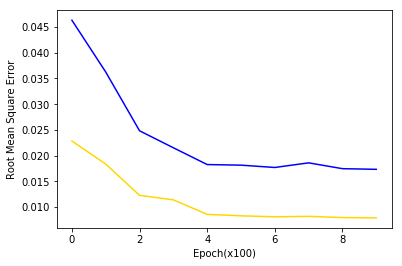

In [6]:
# 결과 그래프 출력

plt.figure(1)
plt.plot(train_error_summary, 'gold')
plt.plot(test_error_summary, 'b')
plt.xlabel('Epoch(x100)')
plt.ylabel('Root Mean Square Error')

In [7]:
test_predict = sess.run(hypothesis, feed_dict={X: testX})
#test_error = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
#test_error_summary.append(test_error)

plt.figure(figsize=(20,5))
#plt.figure()
testY_ = reverse_min_max_scaling(price,testY)
test_predict_ = reverse_min_max_scaling(price,test_predict)

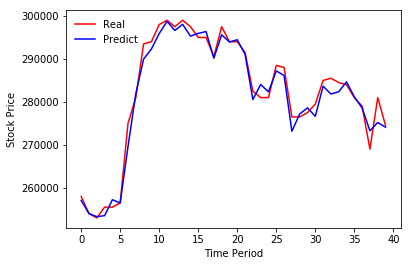

In [8]:
plt.plot(testY_[40:80], color="red", label="Real")
plt.plot(test_predict_[40:80], color="blue", label="Predict")
plt.xlabel('Time Period')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', frameon=False)
plt.show()

In [10]:

# sequence length만큼의 가장 최근 데이터를 슬라이싱한다
recent_data = np.array([x[len(x)-seq_length : ]])
print("recent_data.shape:", recent_data.shape)
print("recent_data:", recent_data)
 
# 내일 종가를 예측해본다
test_predict = sess.run(hypothesis, feed_dict={X: recent_data})
 
print("test_predict", test_predict[0])
test_predict = reverse_min_max_scaling(price,test_predict) # 금액데이터 역정규화한다
print("Tomorrow's stock price", test_predict[0]) # 예측한 주가를 출력한다

recent_data.shape: (1, 4, 5)
recent_data: [[[0.77701149 0.80229885 0.76781609 0.76781609 0.04666923]
  [0.83678161 0.84597701 0.77701149 0.78390805 0.12276277]
  [0.91494253 0.93793103 0.84827586 0.85747126 0.17242419]
  [0.80229885 0.89885057 0.78850575 0.89425287 0.21590093]]]
test_predict [0.78483266]
Tomorrow's stock price [294201.12]


In [9]:
test_predict_list = []
for x in testX:
    test_predict = sess.run(hypothesis, feed_dict={X: testX})


[[0.55632184 0.55632184 0.54022989 0.54482759 0.00781076]
 [0.54252874 0.55632184 0.54022989 0.54482759 0.00565043]
 [0.55402299 0.56091954 0.53793103 0.56091954 0.01822576]
 [0.57241379 0.57931034 0.55632184 0.55632184 0.01732824]]
[[0.54252874 0.55632184 0.54022989 0.54482759 0.00565043]
 [0.55402299 0.56091954 0.53793103 0.56091954 0.01822576]
 [0.57241379 0.57931034 0.55632184 0.55632184 0.01732824]
 [0.57701149 0.5816092  0.56551724 0.5816092  0.01448136]]
[[0.55402299 0.56091954 0.53793103 0.56091954 0.01822576]
 [0.57241379 0.57931034 0.55632184 0.55632184 0.01732824]
 [0.57701149 0.5816092  0.56551724 0.5816092  0.01448136]
 [0.57241379 0.58850575 0.57241379 0.57931034 0.00909288]]
[[0.57241379 0.57931034 0.55632184 0.55632184 0.01732824]
 [0.57701149 0.5816092  0.56551724 0.5816092  0.01448136]
 [0.57241379 0.58850575 0.57241379 0.57931034 0.00909288]
 [0.5908046  0.60689655 0.58390805 0.58390805 0.00830634]]
[[0.57701149 0.5816092  0.56551724 0.5816092  0.01448136]
 [0.572413